## API structure

Input: (ts, val), 

Output: (ts, val)

Steps:

1. Initial disaggregate

2. Clustering

3. **Disaggregate short sequence** <- goal in this notebook
    


**Disaggregate short sequence**

1. set up disaggregation algorithm options: set_disaggregation_option( k, v, [k, v] ): return opt

2. change point detection: cp_detect( v_ts, v_val, opt ): return v_ts_cp

3. compare each segment to existing shapes: get_prob( v_ts, v_val, v_ts_cp, opt ): return cp_likelihood = {(index_of_change_point, [prob_1, prob_2, ...])}

4. viterbi to determine sequence of change: viterbi( cp_likelihood, opt ): return instrument_state_sequence = [{instrument_1:+1, instrument_2:+1, ...}, ...]

5. generate power sequence: power_disaggregate( v_ts, v_val, instrument_state_sequence, opt )

In [3]:
%matplotlib inline

import json
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd

## 1. Set up disaggregation algorithm options

In [4]:
import sys

mod_path = '/Users/Simo//Documents/energyanalytics/energyanalytics/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
    
mod_path = '/Users/Simo//Documents/energyanalytics/energyanalytics/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
    
from bayesian_cp_detect import bayesian_cp_3 as bcp

In [5]:
# make sure that the code is loaded to the lastest version
reload(bcp)

<module 'bayesian_cp_detect.bayesian_cp_3' from '/Users/Simo//Documents/energyanalytics/energyanalytics/disaggregation/bayesian_cp_detect/bayesian_cp_3.pyc'>

In [6]:
# import previously learnt shapes

with open('../metadata/cluster result.json', 'r') as fid:
    var = json.load(fid)
    
cluster_mean_2 = [var[i] for i in [0,1,4,5]]

In [7]:
with open('../metadata/example_shape.json', 'w') as fid:
    json.dump(cluster_mean_2, fid)

In [8]:
opt = bcp.set_disaggregation_option(change_shape=cluster_mean_2, 
                               init_pos_std = np.sqrt([float(200/3), float(200/3), float(400/3), float(400/3)])
                                )

## 2. Change point detection

In [9]:
# helper functions to plot and load data; 
# for this notebook only, not necessary on the server side

def plot_24h_data(t, raw_data, data, cp_list):
    fig, axes = plt.subplots(nrows=4, figsize=[18, 10])
    
    for i, ax in enumerate(axes):
        ax.plot(t, data, 'r-', markersize=3, linewidth=1, label='smooth')
        ax.plot(t, raw_data, 'k.', markersize=3, label='raw')
        
        for cp in cp_list:
            ax.plot([t[cp], t[cp]], [0, 400], 'k-', linewidth=1)
        ax.set_ylabel('power')
        ax.set_xlim([0+i*6,6+i*6])
    ax.set_xlabel('time/h')
    plt.legend()
    
    
def read_dat_0819(date, h_start, h_end, folder_path):
    t = []
    dat = []
    t_utc = []
    start_time = None
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = os.path.join(folder_path, file_name)
            data_pd = pd.read_csv(file_path, names=['time', 'data'])
            time_tmp = pd.to_datetime(data_pd.time,infer_datetime_format=True)
            if not start_time:
                start_time = time_tmp[0]
            tmp = [(x - start_time).seconds/3600. for x in time_tmp]
            t.extend(tmp)
            t_utc.extend(data_pd.time)
            dat.extend( [x/3 for x in data_pd.data] )
        except Exception as inst:
            print type(inst), inst.args, inst     # the exception instance
            print '%s failed' % file_path
#     t_utc = [x.to_datetime() for x in t_utc]
    return t, dat, t_utc

In [10]:
t, raw_data, t_utc = read_dat_0819(datetime.date(2016,4,3), 0, 24, '../new_data/IHG')
_, data = bcp.rel_change_filter_0819_3(range(len(raw_data)), raw_data, thre=.1)
t_data = t

In [11]:
%%time

cp_list = bcp.disaggregate( data, opt )

CPU times: user 3.75 s, sys: 15.9 ms, total: 3.77 s
Wall time: 3.86 s


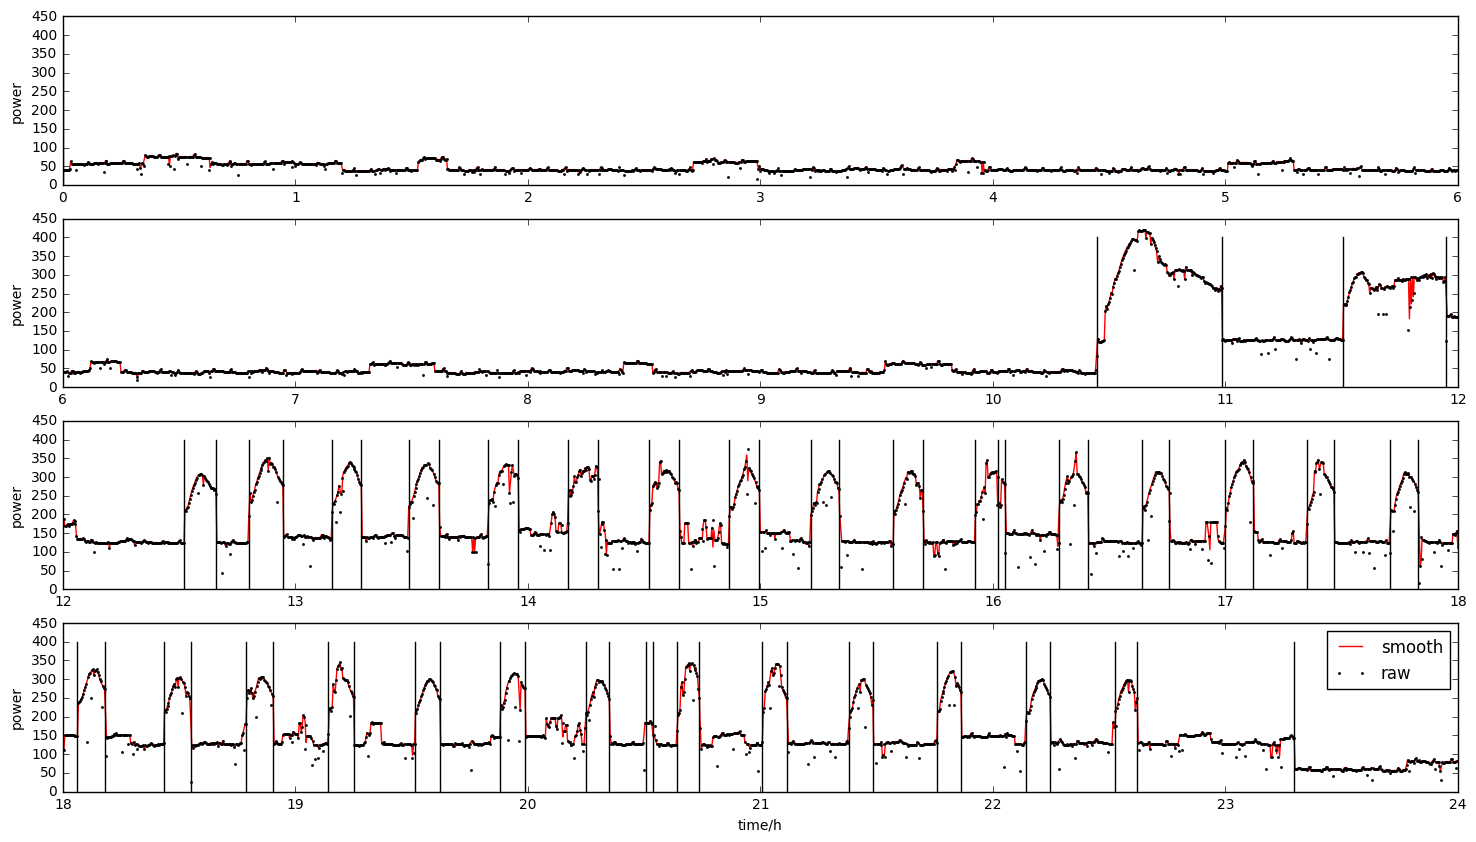

In [12]:
plot_24h_data(t, raw_data, data, cp_list)

## compare each segment to existing shapes

get_prob( v_ts, v_val, v_ts_cp, opt ): return cp_likelihood = {(index_of_change_point, [prob_1, prob_2, ...])}

In [13]:
data_seg, n_seg, data_seg_raw_last = bcp.segment_data(data, cp_list)
n_seg

66

In [14]:
# get shape to compare to

shape_matched = cluster_mean_2[0:2]

# add shapes
shape_matched.append(np.array([75 for _ in range(50)]) )

n_shape_matched = len(shape_matched)
n_shape_matched

3

In [15]:
shape_matched = shape_matched[0:2]
shape_matched.append(np.array([85 for _ in range(50)]))
shape_matched.append(np.array([50 for _ in range(50)]))
n_shape_matched = len(shape_matched)

In [116]:
shape_matched

[[50.145833333333336,
  88.20833333333333,
  87.80208333333334,
  88.17708333333334,
  94.17708333333334,
  103.39583333333334,
  122.52083333333336,
  131.27083333333334,
  135.82291666666666,
  142.22916666666669,
  149.7708333333333,
  163.97916666666666,
  174.79166666666666,
  183.18749999999994,
  183.4791666666666,
  193.31249999999994,
  202.94791666666669,
  212.99999999999991,
  217.5729166666666,
  225.89583333333331,
  227.8020833333333,
  234.14583333333331,
  244.53125000000009,
  242.88541666666669,
  251.6145833333333,
  254.64583333333326,
  252.17708333333331,
  255.90625,
  260.34374999999994,
  256.12499999999994,
  267.40625,
  267.96875,
  268.49999999999994,
  260.34375,
  271.56249999999994,
  256.64583333333337,
  280.3229166666667,
  274.15625,
  280.5833333333333,
  269.5625,
  278.84375,
  270.3333333333333,
  269.65625,
  270.96874999999994,
  276.59375,
  261.92708333333326,
  278.1875,
  267.3645833333333,
  263.59375000000006,
  273.65625],
 [58.50370370

In [53]:
# # generate a dictionary of potential shapes and combined shapes

# shape_dict = {}

# all_shape_code = []
# for shape_code in range(2**n_shape_matched):
#     # generate which shape is used
#     flag_shape_use = []
#     for i_shape in range(n_shape_matched):
#         flag_shape_use.insert(0, shape_code % 2)
#         shape_code = shape_code/2
#     final_shape = []
#     for i_shape in range(n_shape_matched):
#         if flag_shape_use[i_shape]:
#             final_shape.append(shape_matched[i_shape])
#     final_shape = np.sum(np.array(final_shape), axis=0)
#     shape_dict[tuple(flag_shape_use)] = final_shape
#     all_shape_code.append(tuple(flag_shape_use))
# shape_dict[tuple(0 for _ in range(n_shape_matched))] = np.zeros(50)
# all_shape_code

    
all_shape_code = bcp.shape_code_gen(n_shape_matched)
shape_dict = bcp.combine_shape(shape_matched, all_shape_code)
all_shape_code


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

In [54]:
# # now for each segment, match to the shapes

shape_prob_list = bcp.get_seg_prob(data_seg, shape_dict)

In [19]:
shape_dict

{(0,
  0,
  0,
  0): array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 (0,
  0,
  0,
  1): array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]),
 (0,
  0,
  1,
  0): array([85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85]),
 (0,
  0,
  1,
  1): array([135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135,
        135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135,
        135, 135, 135, 135, 135, 135, 

## 4. Viterbi

In [20]:
# set up initial prob
state_prob_list = {(0,0):.91, (0,1):0.03, (1,0):0.03, (1,1):0.03}

# equipment information
n_equipment_type = 2
n_equipment = [1, 1]

# specify equipment and shape mapping
obs_mat = np.array([ [1,1,0], [0,0,1] ])

# TODO!

state_prob_list = {(0,0,0):.05,(0,1,0):0.05,(0,0,1):0.4,(1,0,0):0.15,(1,1,0):0.05,(1,0,1):0.05,(0,1,1):0.05,(1,1,1):0.2}
n_equipment_type = 3
n_equipment = [1,2,1]
obs_mat = np.array([[1,1,0,0], [0,0,1,0],[0,0,0,1]])


In [45]:

trace_list, shape_list = bcp.viterbi(shape_prob_list, state_prob_list, data_seg, obs_mat)
print 'starting', trace_list[0]
for i in range(0, len(shape_list)):
    print 'through', shape_list[i], 'become', trace_list[i+1]

print
print trace_list
print shape_list

[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 1, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, 0, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, -1, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, -1, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, 0, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 1, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0

## 5. dissaggregate power

In [22]:
predicted_profile = bcp.generate_predicted_profile(cp_list, shape_matched, shape_list, raw_data, n_equipment_type, obs_mat, trace_list)


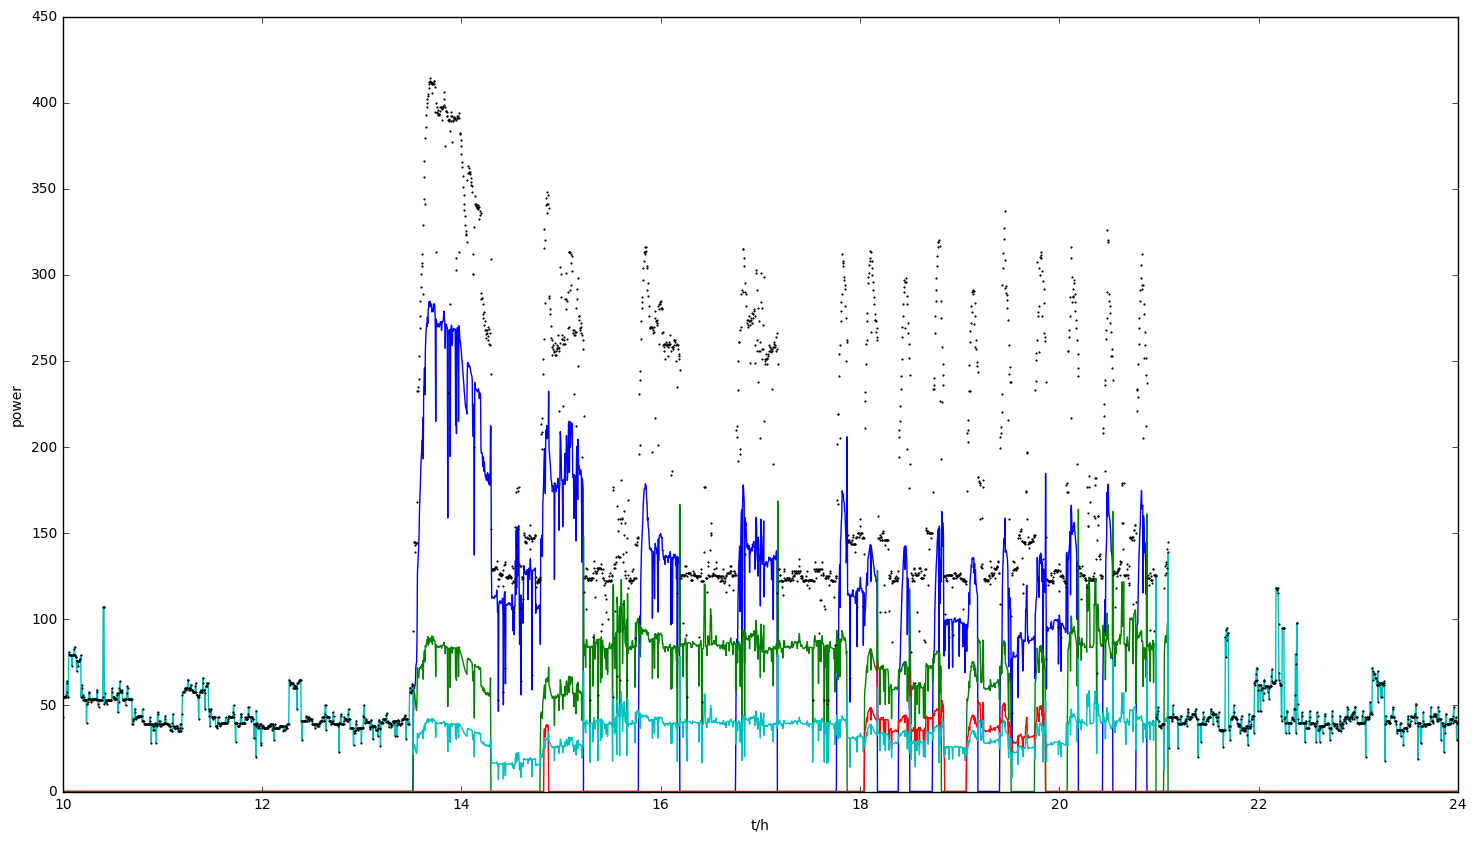

In [30]:
plt.figure(figsize = [18,10])
for tmp in predicted_profile:
    plt.plot(t_data,tmp,linewidth = 1)
plt.plot(t_data,raw_data,'k.',markersize = 2)

plt.xlim([10,24])
plt.xlabel('t/h')
plt.ylabel('power')


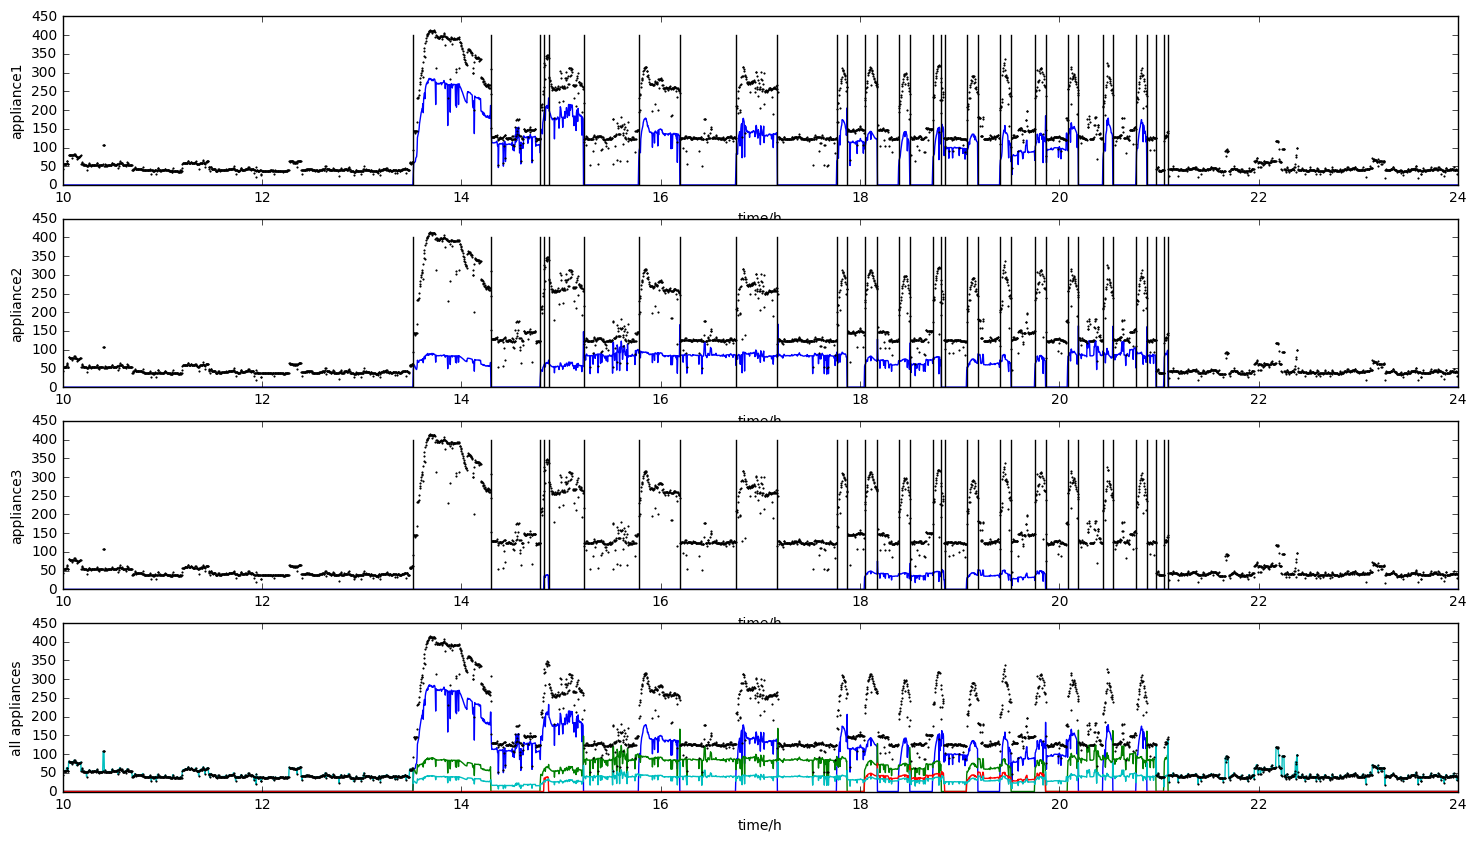

In [98]:

fig,axes = plt.subplots(nrows = len(predicted_profile),figsize = [18,10])
for i,ax in enumerate(axes):
    if i==len(predicted_profile)-1:
        for tmp in predicted_profile:
            ax.plot(t_data,tmp,linewidth = 1)
        ax.plot(t_data,raw_data,'k.',markersize = 2)
        ax.set_xlabel('time/h')
        ax.set_ylabel('all appliances')
        ax.set_xlim([10,24])
    
    else:
        ax.plot(t_data,predicted_profile[i],markersize=3, linewidth=1,label='smooth')
        ax.plot(t_data,raw_data, 'k.', markersize=2, label='raw')
        for cp in cp_list:
            ax.plot([t_data[cp], t_data[cp]], [0, 400], 'k-', linewidth=1)

        ax.set_ylabel('appliance'+str(i+1))
        ax.set_xlabel('time/h')
        ax.set_xlim([10,24])    
            
    
    
plt.legend()



#plt.xlim([10,24])

In [31]:
output = {}
for i, x in enumerate(predicted_profile):
    output[i] = [(y, z)for y,z in zip(t_utc, x)]
    
output.keys()

[0, 1, 2, 3]

In [32]:
# format
t_utc[0]

'2016-04-02 00:00:00+08:00'

In [33]:
with open('../metadata/example_output.json', 'w') as fid:
    json.dump(output, fid)

## 6. One function call

In [99]:
change_shape=cluster_mean_2
init_pos_std = np.sqrt([float(200/3), float(200/3), float(400/3), float(400/3)])
shape_matched = cluster_mean_2[0:2]

# add shapes
shape_matched.append(np.array([75 for _ in range(50)]) )

##########################################
shape_matched = shape_matched[0:2]
shape_matched.append(np.array([85 for _ in range(50)]))
shape_matched.append(np.array([50 for _ in range(50)]))
n_shape_matched = len(shape_matched)
##########################################
state_prob_list = {(0,0):.91, (0,1):0.03, (1,0):0.03, (1,1):0.03}

# equipment information
n_equipment_type = 2
n_equipment = [1, 1]

# specify equipment and shape mapping
obs_mat = np.array([ [1,1,0], [0,0,1] ])

##########################################
state_prob_list = {(0,0,0):.05,(0,1,0):0.05,(0,0,1):0.4,(1,0,0):0.15,(1,1,0):0.05,(1,0,1):0.05,(0,1,1):0.05,(1,1,1):0.2}
n_equipment_type = 3
n_equipment = [1,2,1]
obs_mat = np.array([[1,1,0,0], [0,0,1,0],[0,0,0,1]])


In [62]:
state_prob_list

{(0, 0, 0): 0.05,
 (0, 0, 1): 0.4,
 (0, 1, 0): 0.05,
 (0, 1, 1): 0.05,
 (1, 0, 0): 0.15,
 (1, 0, 1): 0.05,
 (1, 1, 0): 0.05,
 (1, 1, 1): 0.2}

In [100]:
# make sure that the code is loaded to the lastest version
reload(bcp)

<module 'bayesian_cp_detect.bayesian_cp_3' from '/Users/Simo//Documents/energyanalytics/energyanalytics/disaggregation/bayesian_cp_detect/bayesian_cp_3.pyc'>

In [101]:
change_shape = cluster_mean_2
init_pos_std = np.sqrt([float(200/3), float(200/3), float(400/3), float(400/3)])

In [109]:
%%time
predicted_profile = bcp.power_disaggregate(t, 
                           raw_data,
                           change_shape,
                           init_pos_std, 
                           shape_matched, 
                           state_prob_list, 
                           n_equipment_type, 
                           n_equipment, 
                           obs_mat)

[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 1, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, 0, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, -1, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, -1, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (-1, 0, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 1, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, -1, -1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 1, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (1, 0, 1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 0, 1)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, -1, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 0, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0, -1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 1, 1, 0)
[[1 1 0 0]
 [0 0 1 0]
 [0 0 0 1]] (0, 0

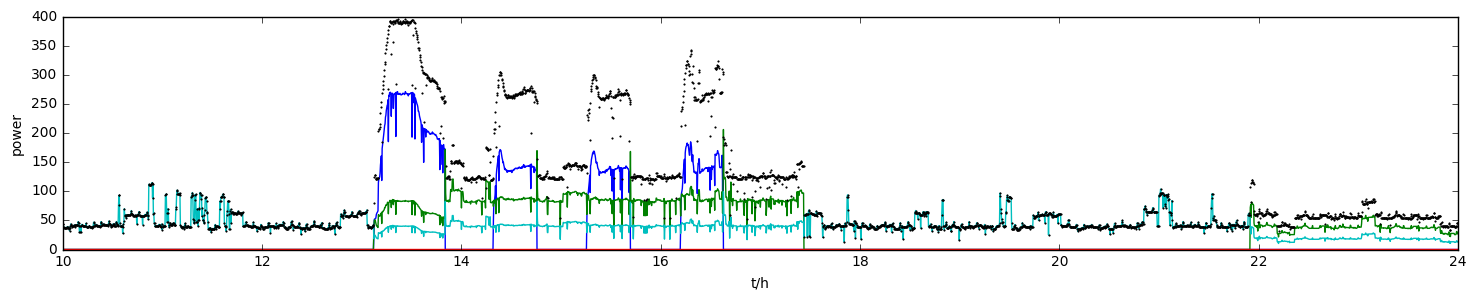

In [106]:
plt.figure(figsize=[18,3])
for tmp in predicted_profile:
    plt.plot(t_data, tmp, linewidth=1)
plt.plot(t_data, raw_data, 'k.', markersize=2)

plt.xlim([10,24])
plt.xlabel('t/h')
plt.ylabel('power')

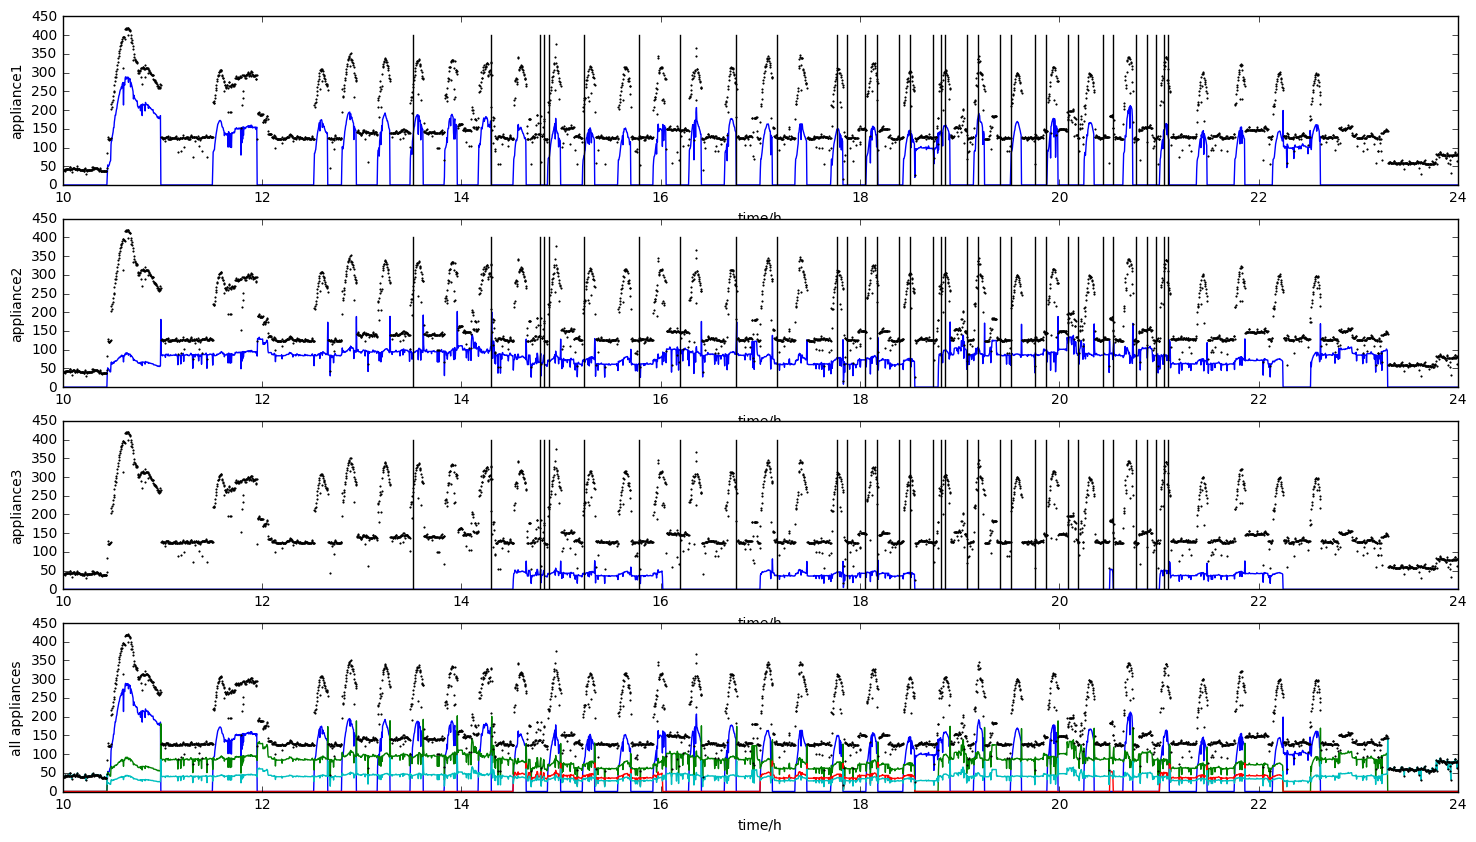

In [110]:

fig,axes = plt.subplots(nrows = len(predicted_profile),figsize = [18,10])
for i,ax in enumerate(axes):
    if i==len(predicted_profile)-1:
        for tmp in predicted_profile:
            ax.plot(t_data,tmp,linewidth = 1)
        ax.plot(t_data,raw_data,'k.',markersize = 2)
        ax.set_xlabel('time/h')
        ax.set_ylabel('all appliances')
        ax.set_xlim([10,24])
    
    else:
        ax.plot(t_data,predicted_profile[i],markersize=3, linewidth=1,label='smooth')
        ax.plot(t_data,raw_data, 'k.', markersize=2, label='raw')
        for cp in cp_list:
            ax.plot([t_data[cp], t_data[cp]], [0, 400], 'k-', linewidth=1)

        ax.set_ylabel('appliance'+str(i+1))
        ax.set_xlabel('time/h')
        ax.set_xlim([10,24])    
            
    
    
plt.legend()



#plt.xlim([10,24])

## 7. multiple equipment

In [16]:
# input:

# about equipment
equipment = [
    {'name': 'HVAC_1', 'power': 100, 'id': 0}, 
    {'name': 'HVAC_2', 'power': 100, 'id': 1}, 
    {'name': 'HVAC_3', 'power': 100, 'id': 2}, 
    {'name': 'pump_1', 'power': 75, 'id': 3}, 
    {'name': 'pump_2', 'power': 75, 'id': 4}, 
    {'name': 'pump_3', 'power': 75, 'id': 5}
]
n_equipment = len(equipment)

print 'n_equipment = ', n_equipment

# data segment
# data_seg, n_seg
print 'n_seg = ', n_seg

# learnt cluster
# cluster_mean_2
shape_matched = [ t for t in cluster_mean_2 if np.mean(t) > 0]
shape_dict = {x:y for x,y in enumerate(shape_matched)}

print 'learnt shapes: ', len(shape_dict)

# mapping from known shapes to equipment, note that this mapping is a n-to-n mapping
shape_2_equip_map = {
    0: [0, 1, 2], # this is saying that shape 0 can be interpretated as equipment 0, 1, 2 change
    1:[0, 1, 2]
}

n_equipment =  6
n_seg =  66
learnt shapes:  2


In [17]:
# def construct_equipment_to_shape_map( equipment, shape_2_equip_map ):
#     equip_2_shape_map = { i['id']:[] for i in equipment }
#     for m in shape_2_equip_map.items():
#         for e in m[1]:
#             equip_2_shape_map[e].append(m[0])
#     return equip_2_shape_map

equip_2_shape_map = bcp.construct_equipment_to_shape_map(equipment, shape_2_equip_map)
equip_2_shape_map

{0: [0, 1], 1: [0, 1], 2: [0, 1], 3: [], 4: [], 5: []}

In [18]:
# def complete_shapes( equip_2_shape_map, shape_2_equip_map, shape_dict, equipment, SHAPE_LEN = 50 ):
#     """
#         for any equipment with no mapped shapes, add a shape based on its power 
#         parameter, and update equip_2_shape_map, shape_2_equip_map, shape_dict
#     """
    
#     # find out ones with no mapping
#     equip_no_shape = [x for x, y in equip_2_shape_map.items() if len(y) == 0]
    
#     for e in equip_no_shape:
#         # find that equipment from equipment
#         t = [x for x in equipment if x['id'] == e ]
#         t = t[0]
        
#         i_shape_to_be_added = len(shape_dict)
#         shape_dict[i_shape_to_be_added] = [ t['power'] ] * SHAPE_LEN
#         shape_2_equip_map[i_shape_to_be_added] = e
#         equip_2_shape_map[ e ].append( i_shape_to_be_added )
    
#     return equip_2_shape_map, shape_2_equip_map, shape_dict

equip_2_shape_map, shape_2_equip_map, shape_dict = bcp.complete_shapes( equip_2_shape_map, 
                                                       shape_2_equip_map, 
                                                       shape_dict, 
                                                       equipment, 
                                                       SHAPE_LEN = 50 )

print 'equip_2_shape_map: ', equip_2_shape_map
print 'shape_2_equip_map:', shape_2_equip_map
print 'len(shape_dict): ', len(shape_dict)

equip_2_shape_map:  {0: [0, 1], 1: [0, 1], 2: [0, 1], 3: [2], 4: [3], 5: [4]}
shape_2_equip_map: {0: [0, 1, 2], 1: [0, 1, 2], 2: 3, 3: 4, 4: 5}
len(shape_dict):  5


In [24]:
def viterbi_2(data_seg, equip_2_shape_map, shape_dict, equipment, data_seg_raw_last, init_state = (0,0,0,0,0,0), init_state_conf = 0.9):
    """
    apply viterbi algorithm to segmented data series
    data_seg: segmented time series, list of list of floats
    equip_2_shape_map: map from int to list of shape id(s)
    equipment: list of equipment specs, including at least an id, and number as the number of equipment
    """

    assert( type( init_state ) is tuple )  # make sure that init_state is tuple

    # viterbi here
    n_seg = len(data_seg)
    n_equipment = len(equipment)

    if len(init_state) != n_equipment:
        raise("No. of appliances does not match: in viterbi_2()")
        
    # Generate probability of all state
    # all_state_list = all_possible_state_helper( equipment )  # generate all possible next state
    # state_prob_list = {
    #     x:( init_state_conf if x == init_state else (1.-init_state_conf)/(len(all_state_list)-1) ) 
    #     for x in all_state_list
    # }
    state_prob_list = get_power_prior(data_seg[0][0], equipment)
    
    best_state_transtion_recorder = []  # more description here
    state_prob_recorder = []  # more description here
    past_state_best_path_recorder = []  # more description here

    for i_seg in range(n_seg):
        # for each segment, repeat the following things: 
        #   for each state, and for each possible last_state, calculate the likelihood that
        #   the transition is supported by data
        seg = data_seg[i_seg]  # segment series

        next_state_list = all_possible_state_helper( equipment )  # all possible next state
        
        next_state_prob_list = { x:0 for x in next_state_list }  # dict to record prob
        past_state_best_list = {  }  # dict from next state to best past state
        past_state_best_path_list = {}  # the correpsonding path

        power_info = get_power_prior( data_seg_raw_last[i_seg], equipment )
        print i_seg, data_seg_raw_last[i_seg], sorted(power_info.items(), key=lambda kv: kv[1], reverse=True)
        print ""

        for next_state in next_state_prob_list.keys():  # for each of the all possible equipment condition combinations
            past_state_prob_recorder = {}  # record the probability
            past_state_prob_path_recorder = {}  # record path to it

            past_state_list = gen_previous_state( next_state, max_change = 2, constraint=[e['number'] for e in equipment ])
            for past_state in past_state_list:
                # note that for each past_state -> next_state, there can be multiple shapes that make this happen,
                # the function "get_prob" is to look up the most probable one
                transition_prob, max_prob_path = get_prob( past_state, next_state, seg, equip_2_shape_map, shape_dict)
                
                n_diff = get_n_diff(next_state, past_state)
                transition_prob = transition_prob / 5.**n_diff
                # print past_state, next_state, n_diff

                transition_prob = transition_prob * power_info[next_state]

                past_state_prob_recorder[ past_state ] = transition_prob * state_prob_list[ past_state ]  # new probability = probability to reach last state * transition probability
                past_state_prob_path_recorder[ past_state ] = max_prob_path
            
            # looking for the best path to this state
            past_state_best = -1
            past_state_best_path = -1
            past_state_best_prob = -np.inf
            for k,v in past_state_prob_recorder.items():
                if v > past_state_best_prob:
                    past_state_best = k
                    past_state_best_prob = v
                    past_state_best_path = past_state_prob_path_recorder[past_state_best]

            next_state_prob_list[next_state] = past_state_best_prob
            past_state_best_list[next_state] = past_state_best
            past_state_best_path_list[next_state] = past_state_best_path

        state_prob_list = next_state_prob_list
        best_state_transtion_recorder.append( past_state_best_list )
        state_prob_recorder.append(next_state_prob_list)
        past_state_best_path_recorder.append(past_state_best_path_list)
    
    return state_prob_list, best_state_transtion_recorder, past_state_best_path_recorder

state_prob_list, best_state_transtion_recorder, past_state_best_path_recorder = bcp.viterbi_2(data_seg, equip_2_shape_map, shape_dict,equipment,data_seg_raw_last,init_state = (0,0,0,1,0,0))

0 419.333333333 [((0, 1, 1, 1, 1, 1), 0.10606666078459641), ((1, 0, 1, 1, 1, 1), 0.10606666078459641), ((1, 1, 0, 1, 1, 1), 0.10606666078459641), ((1, 1, 1, 1, 1, 0), 0.085116694569594781), ((1, 1, 1, 0, 1, 1), 0.085116694569594781), ((1, 1, 1, 1, 0, 1), 0.085116694569594781), ((1, 1, 1, 0, 1, 0), 0.062034588047954968), ((1, 1, 1, 1, 0, 0), 0.062034588047954968), ((1, 1, 1, 0, 0, 1), 0.062034588047954968), ((0, 1, 1, 1, 0, 1), 0.023958560516840512), ((0, 1, 1, 0, 1, 1), 0.023958560516840512), ((1, 0, 1, 1, 0, 1), 0.023958560516840512), ((1, 0, 1, 0, 1, 1), 0.023958560516840512), ((1, 1, 0, 1, 1, 0), 0.023958560516840512), ((1, 1, 0, 1, 0, 1), 0.023958560516840512), ((1, 1, 0, 0, 1, 1), 0.023958560516840512), ((0, 1, 1, 1, 1, 0), 0.023958560516840512), ((1, 0, 1, 1, 1, 0), 0.023958560516840512), ((1, 1, 1, 1, 1, 1), 0.0095380185299972237), ((1, 0, 0, 1, 1, 1), 0.0045526448911486321), ((0, 0, 1, 1, 1, 1), 0.0045526448911486321), ((0, 1, 0, 1, 1, 1), 0.0045526448911486321), ((1, 1, 1, 0, 

In [23]:
equipment

[{'id': 0, 'name': 'HVAC_1', 'number': 1, 'power': 100},
 {'id': 1, 'name': 'HVAC_2', 'number': 1, 'power': 100},
 {'id': 2, 'name': 'HVAC_3', 'number': 1, 'power': 100},
 {'id': 3, 'name': 'pump_1', 'number': 1, 'power': 75},
 {'id': 4, 'name': 'pump_2', 'number': 1, 'power': 75},
 {'id': 5, 'name': 'pump_3', 'number': 1, 'power': 75}]

In [39]:
def back_tracking(state_prob_list, best_state_transtion_recorder, past_state_best_path_recorder, shape_dict):
    trace_list = []
    shape_list = []
    
    n_shape = len(shape_dict)
    
    current_state = -1
    t = -np.inf
    for k, v in state_prob_list.items():
        if v > t:
            t = v
            current_state = k
    for i in reversed(range(len(best_state_transtion_recorder))):
        best_path = past_state_best_path_recorder[i][current_state]
        path_list = [0] * n_shape
        
        best_path = best_path
        for x in best_path:
            x = x[0]
            if x[0] == '+':
                path_list[ int(x[1]) ] = 1
            else:
                try:
                    path_list[ int(x[1:]) ] = -1
                except:
                    path_list[ int(x[1:]) ] = -1
        
        trace_list.insert(0, current_state)
        shape_list.insert(0, path_list)
        
        current_state = best_state_transtion_recorder[i][current_state]
    trace_list.insert(0, current_state)
    return trace_list, shape_list

trace_list, shape_list = bcp.back_tracking(state_prob_list, best_state_transtion_recorder, past_state_best_path_recorder, shape_dict)
print trace_list
print shape_list

NameError: name 'best_state_transtion_recorder' is not defined

[0.0,
 74302.428754618872,
 0.0,
 297182.95228935656,
 67636.952289357228,
 0.0,
 0.0]

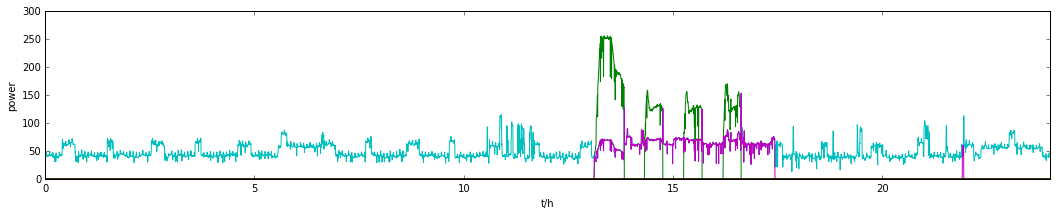

In [31]:
def generate_predicted_profile_2(cp_list, shape_matched, shape_list, raw_data, n_equipment_type, equip_2_shape_map, trace_list, equipment, SHAPE_LEN = 50):

    predicted_profile = [ [] for _ in range(n_equipment_type+1) ]
    
    basal_noise = 1
    predicted_profile[n_equipment_type].extend( [basal_noise for _ in range(len(raw_data))] )
    
    for i_equipment in range(n_equipment_type):
        for i_cp in range(len(cp_list)):
            t_start = cp_list[i_cp]
            if i_cp == len(cp_list)-1:
                t_end = len(raw_data)
            else:
                t_end = cp_list[i_cp+1]
            if trace_list[i_cp][i_equipment] == 0:
                predicted_profile[i_equipment].extend([0 for _ in range(t_end-t_start)])
            else:
                if i_cp == 0 or (trace_list[i_cp][i_equipment] == trace_list[i_cp-1][i_equipment]):
                    if i_cp == 0:
                        last_datum = equipment[i_equipment]['power']
                    else:
                        last_datum = predicted_profile[i_equipment][-1]
                    predicted_profile[i_equipment].extend([last_datum for _ in range(t_end-t_start)])
                else:
                    change_profile = []

                    for i_shape in range(len(shape_list[0])):
                        if (i_shape in equip_2_shape_map[i_equipment]) > 0:
                            if shape_list[i_cp-1][i_shape] > 0:
                                change_profile.append(shape_matched[i_shape])
                            elif shape_list[i_cp-1][i_shape] < 0:
                                change_profile.append([ -shape_matched[i_shape][-1] ]*SHAPE_LEN)

                    if len(change_profile) > 1:
                        change_profile = np.sum(change_profile, axis=0)
                    else:
                        change_profile = change_profile[0]

                    if i_cp == 0:
                        last_datum = equipment[i_equipment]['power']
                    else:
                        last_datum = predicted_profile[i_equipment][-1]

                    change_profile = [ last_datum + x for x in change_profile]

                    if (t_end-t_start) > len( shape_matched[i_shape] ):
                        predicted_profile[i_equipment].extend( list(change_profile) )
                        predicted_profile[i_equipment].extend( [change_profile[-1] for _ in range(t_end-t_start-len( shape_matched[i_shape] ))] )
                    else:
                        predicted_profile[i_equipment].extend( change_profile[:t_end-t_start] )
                   
    power_sum = np.sum(predicted_profile, axis=0)
    predicted_profile_2 = [np.multiply(raw_data, np.divide(t, power_sum)) for t in predicted_profile]
    # predicted_profile_2 = predicted_profile
    
    return predicted_profile_2

predicted_profile = bcp.generate_predicted_profile_2(cp_list, shape_dict, shape_list, raw_data, len(equipment), equip_2_shape_map, trace_list, equipment)
len(predicted_profile)

plt.figure(figsize=[18,3])
for tmp in predicted_profile:
    plt.plot(t_data, tmp, linewidth=1)
# plt.plot(t_data, raw_data, 'k-', markersize=2)

plt.xlim([0,24])
plt.xlabel('t/h')
plt.ylabel('power')

[sum(x) for x in predicted_profile]

In [45]:
def get_prob( past_state, next_state, seg, equip_2_shape_map, shape_dict, SHAPE_LEN = 50, var_measurement = 800, verbose = 0 ):
    """calculate the probability that seg is generated by any pathway from past_state to next_state"""
    all_possible_shape = [[0] * SHAPE_LEN]
    all_possible_shape_path = [ [] ]
    
    # do not allow shut down and turn on together, this can be relaxed if needed
    flag = 0
    for i in range(len(past_state)):  
        if flag == 0 and past_state[i] != next_state[i]:
            flag = past_state[i] - next_state[i]
            continue
        if flag != 0 and past_state[i] != next_state[i]:
            if flag != (past_state[i] - next_state[i]):
                return -np.inf, []
    
    for pos in range(len(past_state)):
        if (past_state[pos] == next_state[pos]):  # this equipment is not changed
            continue
        else:
            all_possible_shape_new = []
            all_possible_shape_path_new = []
            for base_shape, path in zip(all_possible_shape, all_possible_shape_path):
                for i_shape in equip_2_shape_map[pos]:  # only allow changing through the same shape
                    old_path = copy.copy(path)
                    # tmp = [x for x in path]  # copy
                    if next_state[pos] < past_state[pos]: # shut down
                        add_value = [ (next_state[pos]-past_state[pos]) * shape_dict[i_shape][-1]] * SHAPE_LEN
                        if (len(old_path)==pos+1): # this is not the first time, the 'pos' equipment change status
                            old_path[pos] = (old_path[pos][0] + '-'+str(i_shape) ,)
                        else:
                            old_path.append( ('-'+str(i_shape),) )
                    else: # turn on
                        add_value = shape_dict[i_shape]
                        add_value = [x * (next_state[pos]-past_state[pos]) for x in add_value]
                        if (len(old_path) == pos+1):
                            old_path[pos] = (old_path[pos][0] + '+'+str(i_shape), )
                        else:
                            old_path.append( ('+'+str(i_shape),) )
                    all_possible_shape_new.append( [ x+y for x, y in zip(base_shape, add_value) ] )
                    all_possible_shape_path_new.append(old_path)
            all_possible_shape = all_possible_shape_new
            all_possible_shape_path = all_possible_shape_path_new

    if verbose:
        print all_possible_shape
        print all_possible_shape_path

    # look up most probable path
    max_prob = -np.inf
    max_prob_path = -1
    for t, t2 in zip(all_possible_shape, all_possible_shape_path):
        prob = np.exp( -l2_distance(seg, t) / var_measurement )
        if prob > max_prob:
            max_prob = prob
            max_prob_path = t2
    return max_prob, max_prob_path
    

# a,b = get_prob( (0, 1, 0, 1, 0, 0), (0, 0, 0, 0, 0, 0), data_seg[10], equip_2_shape_map, shape_dict )
# print a, b


In [33]:
def gen_previous_state(next_state, max_change = 2, allow_pos = 0, constraint = None):
    n_equip = len(next_state)
    if not constraint:
        constraint = [1] * n_equip

    if allow_pos == n_equip and max_change > 0:
        return [tuple(next_state)]
    if max_change == 0:
        return [tuple(next_state)]
    result = [tuple(next_state)];
    
    for i in range( allow_pos, n_equip ):
        for j in range(-max_change, max_change+1):
            if j == 0:
                continue
            new_next_state = [t for t in next_state]  # copy next_state
            new_next_state[i] = new_next_state[i] + j
            if (new_next_state[i] < 0 or new_next_state[i]>constraint[i]):
                continue
            else:
                t = gen_previous_state(new_next_state, max_change = max_change-abs(j), allow_pos = i+1, constraint = constraint)
                result.extend( t )
    return result

# print gen_previous_state( [0,0,0,0], 2 )

In [46]:
def all_bin_state_helper(n):
    result = []
    for i in range( 2**n ):
        result.append( int2bin(i, n) )
    return result

def int2bin(i, n):
    result = []
    while n > 0:
        result.append( i % 2 )
        i /= 2
        n -= 1
    return tuple(result)

# print int2bin(11, 4)
# print all_bin_state_helper(6)
# print (0,1) == (0, 1)